## Analiza toponima na Balkanu

Analiza toponima (geografskih imena) u bivšim jugoslovenskim republikama i regionu, s fokusom na sličnosti imena naseljenih mjesta i njihove geografske distribucije. Podaci su preuzeti iz [GeoNames](https://download.geonames.org/export/dump/) baze podataka, koja sadrži skup geografskih informacija za mjesta širom svijeta, uključujući njihove koordinate, različite klasifikacije i alternativna imena.


# Metodologija
1. Za prepoznavanje sličnosti između imena naseljenih mјesta koristićemo biblioteku RapidFuzz, koja omogućava jednostavno poređenje stringova na osnovu njihove sličnosti. Uporedićemo svako ime naseljenog mјesta sa svim ostalim u datasetu i izdvojiti one parove koji imaju visoku sličnost (na osnovu Levenshtein distance).

2. Nakon što prepoznamo slična imena, koristićemo njihove geografske koordinate da bismo vidjeli da li se ta mjesta nalaze u blizini ili pokrivaju određene regije. U ovoj fazi će biti korisno da mapiramo mjesta i provjerimo da li se pojavljuju obrasci ili koncentracije sličnih toponima u određenim geografski bliskim oblastima.

3. Vizualizovaćemo rezultate na interaktivnim mapama kako bismo lakše analizirali gdje se slična imena pojavljuju i kako su raspoređena.

# Dalji koraci
* Klasifikacija i grupisanje sličnih toponima u klastere na osnovu njihovih imena i geografskih lokacija.

* Analiza i upoređivanje rezultata sa istorijskim podacima migracija, ako su dostupni, kako bi se istražile moguće migracijske veze među regionima.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install geopandas fuzzywuzzy python-Levenshtein contextily scikit-learn

In [ ]:
import pandas as pd

path = "/content/drive/MyDrive/toponym_project/allCountries.csv"

df = pd.read_csv(path)
df.head()

,geonameid,asciiname,altnames,latitude,longitude,featureclass,featurecode,countrycode,population,elevation,dem,timezone
0,3186320,Zubovici,NaN,44.36644,17.42078,P,PPL,BA,0,NaN,1176,Europe/Sarajevo
1,3186351,Zovik,NaN,43.78383,18.17238,P,PPL,BA,0,NaN,621,Europe/Sarajevo
2,3186749,Zaselje,NaN,44.27998,17.77581,P,PPL,BA,0,NaN,785,Europe/Sarajevo
3,3186750,Zaselje,NaN,44.13880,17.71419,P,PPL,BA,0,NaN,688,Europe/Sarajevo
4,3186755,Zasavica,NaN,44.40763,17.40266,P,PPL,BA,0,NaN,778,Europe/Sarajevo


# Priprema podataka

Podaci o toponimima su učitani iz CSV fajla koji sadrži informacije iz zemalja širom svijeta. U datasetu se nalaze podaci poput imena naseljenih mesta, njihovih koordinata (širina i dužina), populacije i različitih administrativnih kodova.

Za analizu smo odabrali samo relevantne kolone koje uključuju imena naseljenih mјesta i njihove geografske koordinate, dok su ostali podaci zanemareni.

In [ ]:
df = df.rename(columns={'asciiname': 'name'})
print(df.columns)

Index(['geonameid', 'name', 'altnames', 'latitude', 'longitude',
       'featureclass', 'featurecode', 'countrycode', 'population', 'elevation',
       'dem', 'timezone'],
      dtype='object')


In [ ]:
print(df['countrycode'].unique())

['BA' 'HR' 'BG' 'GR' 'ME' 'MK' 'RS' 'XK' nan 'TR' 'AT' 'YU' 'GB' 'RO' 'CD'
 'CY' 'IQ' 'DE' 'CS']


In [ ]:
df = df.dropna(subset=['countrycode'])

In [ ]:
unwanted_codes = ['BG', 'GR', 'TR', 'AT', 'YU', 'GB', 'RO', 'CD', 'CY', 'IQ', 'DE', 'CS', 'XK']

In [ ]:
df = df[~df['countrycode'].isin(unwanted_codes)]

In [ ]:
print(df['countrycode'].unique())

['BA' 'HR' 'ME' 'MK' 'RS']


In [ ]:
print(df['timezone'].unique())

['Europe/Sarajevo' 'Europe/Zagreb' 'Europe/Podgorica' 'Europe/Skopje'
 'Europe/Belgrade' 'Europe/Sofia']


In [ ]:
df = df[df['timezone'] != 'Europe/Sofia']

Posto nam za analizu nisu potrebni toponyms koji se odnose na gradjevine, puteve ili podvodne tacke, izbacicemo iz DataFrame takve uzorke:

In [ ]:
df = df[~df['featureclass'].isin(['H', 'L', 'R', 'S', 'U', 'V'])]
df.head()

,geonameid,name,altnames,latitude,longitude,featureclass,featurecode,countrycode,population,elevation,dem,timezone
0,3186320,Zubovici,NaN,44.36644,17.42078,P,PPL,BA,0,NaN,1176,Europe/Sarajevo
1,3186351,Zovik,NaN,43.78383,18.17238,P,PPL,BA,0,NaN,621,Europe/Sarajevo
2,3186749,Zaselje,NaN,44.27998,17.77581,P,PPL,BA,0,NaN,785,Europe/Sarajevo
3,3186750,Zaselje,NaN,44.13880,17.71419,P,PPL,BA,0,NaN,688,Europe/Sarajevo
4,3186755,Zasavica,NaN,44.40763,17.40266,P,PPL,BA,0,NaN,778,Europe/Sarajevo


Cuvam ovaj DataFrame za dalji rad:

In [ ]:
df.to_csv("/content/drive/MyDrive/toponym_project/toponimi_yu.csv", index=False)

# Prepoznavanje obrazaca u imenima toponima (prefiksi/sufiksi)
Prvo ćemo koristiti regularne izraze da bismo prepoznali uobičajene prefikse i sufikse u imenima toponima.
Ako se pojavi bilo koja od riječi koja počinje sa delovima kao što su "Gornj", "Donj" itd, regularni izraz će se poklopiti sa početkom imena toponima.
\w* znači da mogu da se dodaju bilo koji karakteri (slova ili brojevi) posle osnovnog korena.

In [ ]:
path = "/content/drive/MyDrive/toponym_project/toponimi_yu.csv"

df = pd.read_csv(path)

In [ ]:
translit_rules = {
    'sh': 's',
    'ch': 'c',
    'dj': 'd',
    'zh': 'z',
    'ts': 'c',
    'ya': 'ja',
    'yu': 'ju',
    'yo': 'jo',
    'iy': 'i',
    'y': 'i',
    'q': 'c',
}

def transliterate(name, rules):
    for rule, replacement in rules.items():
        name = re.sub(rule, replacement, name, flags=re.IGNORECASE)
    return name

In [ ]:
import re

def extract_prefix(name):
    prefixes = ['svet','gornj', 'donj', 'velik', 'mal', 'nov', 'srpsk', 'srednj', 'star', 'nov', 'selce', 'selo', 'opstina', 'opcina', 'kamen', 'otok', 'otocic', 'kriv']
    for prefix in prefixes:
        if name.lower().startswith(prefix):
            return prefix
    return ''


def extract_suffix(name):
    suffixes = ['donji', 'gornji', 'donja', 'gornja', 'greda', 'kamen', 'dolina', 'doline', 'brdo', 'strana', 'draga', 'maala', 'mahala', 'grad', 'mesto', 'planina', 'glava', 'glav', 'glavica', 'han', 'mala', 'ponor', 'potok', 'selo', 'voda', 'breg', 'brijeg', 'rid', 'ari', 'ovi', 'ak', 'ik', 'dol', 'ina', 'ija', 'ika', 'vrh', 'kosa', 'cuka', 'polje', 'do', 'ovo', 'evo', 'vo', 'ovaca', 'vaca', 'aca', 'ska', 'ski', 'sko', 'cki', 'cka', 'sta', 'ik', 'ic', 'ilje', 'elje', 'ovlje', 'avlje', 'lje', 'elj', 'ilja', 'lja', 'anka', 'avka', 'ovka', 'inka', 'ka', 'inac', 'ovac', 'ac', 'ica', 'ice', 'usa', 'ani', 'aci', 'ici', 'ci', 'ece', 'uce', 'inje', 'enje', 'ilje', 'elje', 'anja']
    for suffix in suffixes:
        if name.lower().endswith(suffix):
            return suffix
    return ''

def clean_prefix_suffix(name):
    name = re.sub(r'^(svet|gornj|donj|velik|mal|nov|srpsk|srednj|star|nov|selce|selo|opstina|opcina|kamen|otok|otocic|kriv)\w*', '', name, flags=re.IGNORECASE)
    name = re.sub(r'\s*(donji|donja|gornji|gornja|greda|kamen|dolina|doline|brdo|strana|draga|maala|mahala|grad|mesto|planina|glava|glav|glavica|han|mala|ponor|potok|selo|voda|breg|brijeg|rid|ari|ovi|ak|ik|dol|ina|ija|ika|vrh|kosa|cuka|polje|do|ovo|evo|vo|ovaca|vaca|aca|ska|ski|sko|cki|cka|sta|ik|ic|ilje|elje|ovlje|avlje|lje|elj|ilja|lja|anka|avka|ovka|inka|ka|inac|ovac|ac|elje|ica|ice|usa|ani|aci|ici|ci|ece|uce|inje|enje|ilje|elje|anja)$', '', name, flags=re.IGNORECASE)
    return name.strip()

def normalize_toponym(name):
    return name.lower().strip()

In [ ]:
names = ['Sveti Petar', 'Starin', 'Svetin', 'Gornji Grad', 'Malin']
cleaned_names = [clean_prefix_suffix(name) for name in names]
print(cleaned_names)

['Petar', '', '', '', '']


Kreiramo novu kolonu normalizovanih imena, iz kojih cemo izbaciti prefikse/sufikse da bi dobili homogenije klastere po korijenu imena:

In [ ]:
df['transliterated_name'] = df['name'].apply(lambda x: transliterate(x, translit_rules))

df['prefix'] = df['transliterated_name'].apply(lambda x: extract_prefix(x))
df['suffix'] = df['transliterated_name'].apply(lambda x: extract_suffix(x))

df['base_name'] = df['transliterated_name'].apply(clean_prefix_suffix)

df['normalized_name'] = df['base_name'].apply(normalize_toponym)

In [ ]:
print(df[['geonameid', 'name', 'prefix', 'suffix', 'base_name', 'normalized_name']].tail())

        geonameid              name prefix suffix   base_name normalized_name
101723   12509508            Osunja                    Osunja          osunja
101724   12509509            Poklek                    Poklek          poklek
101725   12509510  Selce Zumberacko  selce         Zumberacko      zumberacko
101726   12509511      Sipacki Breg          breg     Sipacki         sipacki
101727   12514106    Velika Jazbina  velik    ina        Jazb            jazb


In [ ]:
ba_df = df[df['countrycode'] == 'BA']
print(ba_df[['geonameid', 'name', 'prefix', 'suffix', 'base_name', 'normalized_name']].head(50))

    geonameid          name prefix suffix base_name normalized_name
0     3186320      Zubovici           ici     Zubov           zubov
1     3186351         Zovik            ik       Zov             zov
2     3186749       Zaselje          elje       Zas             zas
3     3186750       Zaselje          elje       Zas             zas
4     3186755      Zasavica           ica     Zasav           zasav
5     3186789        Zapece           ece       Zap             zap
6     3186835       Zaljuce           uce      Zalj            zalj
7     3187008       Zabilje          ilje       Zab             zab
8     3187035        Vukovo           ovo       Vuk             vuk
9     3187036        Vukovo           ovo       Vuk             vuk
10    3187050      Vukotici           ici     Vukot           vukot
11    3187246         Vrela                   Vrela           vrela
12    3187383        Vranci            ci      Vran            vran
13    3187515      Vlasinje          inje      V

Cuvam DataFrame sa normalizovanim imenima za dalju upotrebu:

In [ ]:
df.to_csv("/content/drive/MyDrive/toponym_project/toponimi_norm.csv", index=False)

# Klasterska analiza na osnovu sličnosti imena

Cilj:
Grupisati toponime prema strukturalnoj i fonetskoj sličnosti imena, sa idejom da se kroz formirane klastere prepoznaju istorijski migracioni obrasci, kulturna prožimanja ili lokalne varijacije u nazivima

Koraci:
1. Priprema podataka - uzimamo jedinstvena imena, bez ponavljanja

In [ ]:
path = "/content/drive/MyDrive/toponym_project/toponimi_norm.csv"

df = pd.read_csv(path)

<ipython-input-5-006cc7f4d467>:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [ ]:
names = df['normalized_name'].dropna().unique().tolist()

2. Koristimo TfidfVectorizer sa analizom po karakterima (ne po riječima) i ngram_range=(2, 4) da bismo uhvatili kratke uzorke koji su zajednički sličnim toponimima, poput -ica, -ovac, gornj, itd.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4))
X = vectorizer.fit_transform(names)

char_wb: uzima n-grame unutar riječi (preskače razmake na granicama).

(2,4): kombinuje bigrame, trigrame i tetragrame - korisno za sufikse/prefikse

3. Treniranje KMeans algoritma - pocecemo sa 10 klastera i provjeriti koja raspodjela je najbolja

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=10, random_state=42)

4. Kreiramo novi DataFrame koji prikazuje ime i njegov klaster.

In [ ]:
df_clusters = pd.DataFrame({
    'name': names,
    'cluster': kmeans.labels_

})

5. Analiza klastera, koje toponime KMeans svrstava zajedno:

In [ ]:
for c in range(n_clusters):
    print(f"\nKlaster {c}")
    print(df_clusters[df_clusters['cluster'] == c]['name'].sample(10, random_state=42).to_list())


Klaster 0
['kuna gora', 'skinato', 'viranj', 'silnj', 'botanj', 'cudanj', 'solacka sena', 'kulincinja', 'banacka pal', 'vlajna']

Klaster 1
['buzin', 'grosn', 'graberje', 'rt gruj', 'grcko gropce', 'gradeska', 'grobot', 'zgrade', 'gradise', 'dejkin']

Klaster 2
['desil', 'celj', 'zirca', 'gnjili', 'resovo', 'rt konoplji', 'davilec', 'mamt', 'dzur', 'njegus']

Klaster 3
['jankovacki', 'jame pelinkovacke', 'leskova osoj', 'brova', 'petrova', 'zegrova', 'brdo sava', 'stolovat', 'mustafova niva', 'popova kor']

Klaster 4
['petrovice donje', 'petrcane', 'pocrte', 'ede', 'skabrnje', 'pluzine', 'katunske drage', 'derneciste', 'jablan gariste', 'sirade']

Klaster 5
['zar', 'ici karadas', 'tarni', 'barbara', 'crveni karpi', 'skarb', 'belaski cukar', 'cefar', 'palanski cukar', 'cakarevo']

Klaster 6
['unsko-sanski kanton', 'prica', 'jok bunarski', 'vasilica', 'strnjacki', 'jovandica', 'strelicki krs', 'klecarski vrh', 'kosaracki livadi', 'kukuvecki']

Klaster 7
['poljansko', 'sipovec', 'dimkov'

# Vizualizacija klastera na mapi
Nakon što smo grupisali toponime u klastere, možemo prikazati njihov geografski raspored na mapi. U ovoj analizi koristimo GeoPandas da bismo vizualizovali klastere na mapi koristeći geografske koordinate.

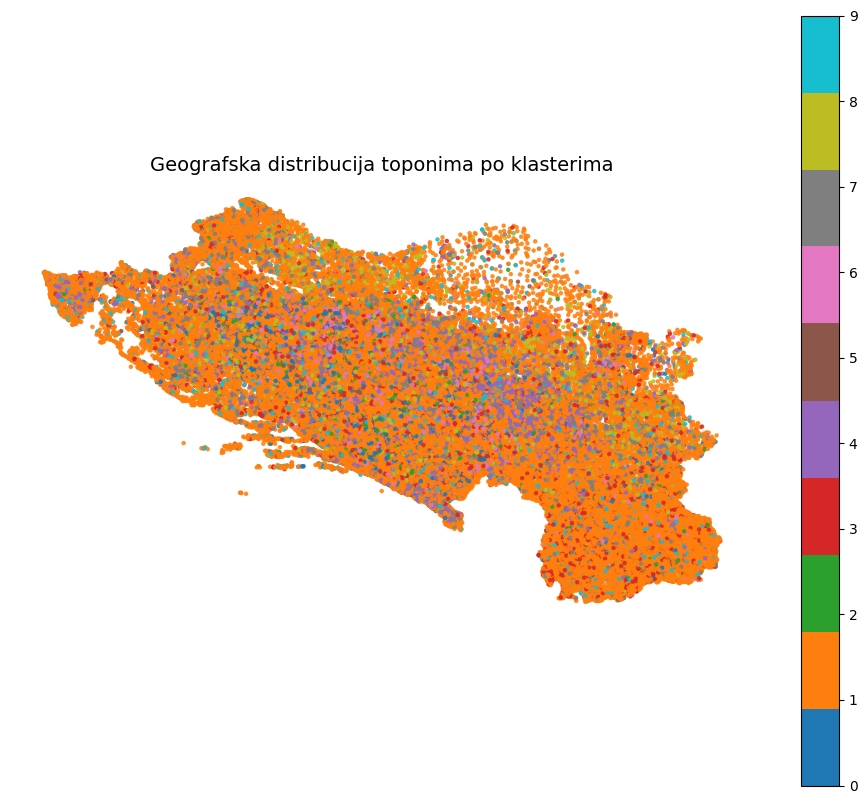


Cluster 0:
 - Lupoglav
 - Slavici
 - Glavica
 - Glavasi
 - Glavice

Cluster 1:
 - Zovik
 - Zaselje
 - Zaselje
 - Zasavica
 - Zapece

Cluster 2:
 - Gradina
 - Grad
 - Paradina
 - Vinogradi
 - Radici

Cluster 3:
 - Starina
 - Prisoje
 - Jastrebac
 - Bistrica
 - Stranjani

Cluster 4:
 - Zubovici
 - Vidovici
 - Suljici
 - Stuparici
 - Smajici

Cluster 5:
 - Prokosa
 - Doganova Kosa
 - Osoje
 - Osoje
 - Osoje

Cluster 6:
 - Malica Brdo
 - Skrobino Brdo
 - Zabrdo
 - Brdo
 - Brdo

Cluster 7:
 - Donja Lupnica
 - Donji Kamicak
 - Gunjani
 - Gornji Visnjani
 - Gornji Orasac

Cluster 8:
 - Kovacevo Polje
 - Puljkovac
 - Kovaci
 - Kubrovaca
 - Visokovac

Cluster 9:
 - Vukotici
 - Mratinici
 - Margetici
 - Ljetinic
 - Gotici


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. TF-IDF karaktera iz 'name' kolone
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))
X = vectorizer.fit_transform(df['name'].astype(str))

# 2. KMeans klasterovanje
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
df['cluster'] = kmeans.fit_predict(X)

# 3. Pretvaranje u GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# 4. Vizualizacija po klasterima
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, column='cluster', cmap='tab10', legend=True, markersize=5, alpha=0.8)
plt.title("Geografska distribucija toponima po klasterima", fontsize=14)
plt.axis('off')
plt.show()

# Print examples from each cluster
for cluster_id in range(n_clusters):
    cluster_examples = df[df['cluster'] == cluster_id]['name'].head(5).tolist()  # 5 examples per cluster
    print(f"\nCluster {cluster_id}:")
    for name in cluster_examples:
        print(f" - {name}")

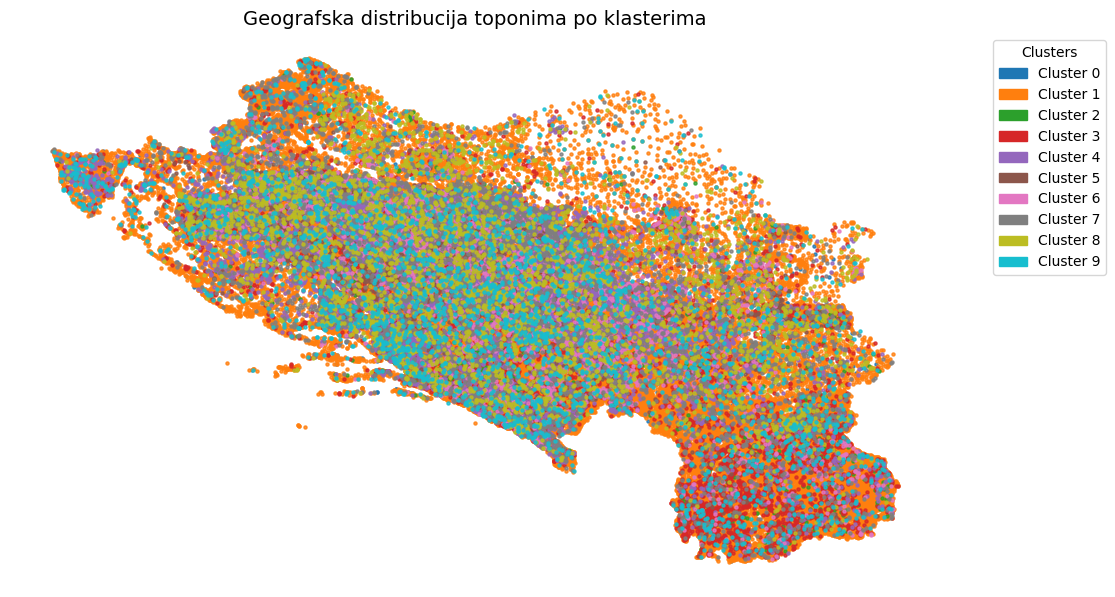

In [ ]:
import matplotlib.patches as mpatches

cmap = plt.get_cmap('tab10')
colors = [cmap(i % 10) for i in df['cluster']]

gdf['color'] = colors

fig, ax = plt.subplots(figsize=(12, 10))
for cluster_id in range(n_clusters):
    cluster_gdf = gdf[gdf['cluster'] == cluster_id]
    cluster_gdf.plot(ax=ax, color=cmap(cluster_id % 10), markersize=5, label=f'Cluster {cluster_id}', alpha=0.8)

handles = [mpatches.Patch(color=cmap(i % 10), label=f'Cluster {i}') for i in range(n_clusters)]
plt.legend(handles=handles, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Geografska distribucija toponima po klasterima", fontsize=14)
plt.axis('off')
plt.show()